#COMP 579 Assignment 2

Team: Jerry Zhu (260205780), Tianhao Xie (260954275)

1. Importing libraries and packages

In [ ]:
!pip install gymnasium
!pip install gymnasium[toy-text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gymnasium as gym
import numpy as np
import random
from tqdm import trange 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi")

Boltzmann/Softmax Exploration

In [ ]:
def softmax(Q, state, theta=0.001):
  prob = []
  tot = 0
  for a in range(len(Q[state, :])):
    prob.append(np.exp(Q[state,a]/theta))
    tot += np.exp(Q[state,a]/theta)
  prob /= tot
  #print(prob)
  return np.random.choice(4, p=prob)

Greedy Exploration

In [ ]:
def greedy(state, Q):
  return max(list(range(env.action_space.n)), key = lambda x: Q[state,x])

In [ ]:
def epsilon_greedy(state, Q, epsilon=0.5):
  if np.random.random() <= epsilon:
      return np.random.randint(4)
  else:
      return np.argmax(Q[state, :])


SARSA

In [ ]:
def sarsa(num_segments = 500, theta = 0.001, alpha = 0.85, gamma = 0.90):
  
  # initializing Q reward function

  Q = np.zeros([env.observation_space.n, env.action_space.n])

  # 500 segments, each segment is 10 episodes training and 1 episode testing

  train = []
  test = []

  for j in range(num_segments):

    # for each segment, we have 10 initial training episodes

    for i in range(10): 

        s = env.reset()[0]
        
        #a = softmax(Q, s, theta = theta)
        a = epsilon_greedy(s, Q)

        reward = 0
        k = 0 # k is the number of time steps for gamma discount parameter

        done = False

        while not done: # no time step limit for training given softmax 

          s_, r, done, _, _ = env.step(a)

          #a_ = softmax(Q, s_, theta = theta)
          a_ = epsilon_greedy(s, Q)
            
          Q[s,a] += alpha * (r + (gamma * Q[s_,a_]) -Q [s,a])

          reward += gamma**k * r 

          s = s_
          a = a_

          k+=1
        
        train.append(reward)

    # for each segment, we have 1 testing episode

    s = env.reset()[0]
    a = greedy(s, Q) # pick the action greedily (Q value)

    reward = 0
    k = 0

    for t in range(100): # we set a time step limit in case optimal actions 
    # cause the player to be stuck (e.g. 'UP' for the top row, so either stuck 
    # in place or moving perpendicular/LEFT/RIGHT)

      s_, r, done, _, _ = env.step(a)
      a_ = greedy(s, Q)
      reward += gamma**k * r
      s = s_
      a = a_
      k+=1
      if done:
        break

    test.append(reward)  

  return Q, train, test

Let us visualize the optimal policy from SARSA training on 500 segments.

In [ ]:
Q, train, test = sarsa(num_segments = 500, 
                       theta = 0.01, 
                       alpha = 0.1, 
                       gamma = 0.99)

print(np.array([greedy(s, Q) for s in range(16)]).reshape(4,4))

'''
0: LEFT

1: DOWN

2: RIGHT

3: UP
'''

print(env.render())
print(np.mean(train))

[[3 1 0 3]
 [0 0 2 0]
 [1 1 0 0]
 [0 2 3 0]]
  (Down)
SFFF
FHFH
FFFH
HFFG

0.0179067831457942


Expected SARSA

We use the following equation as policy where epsilon is fixed at 0.1

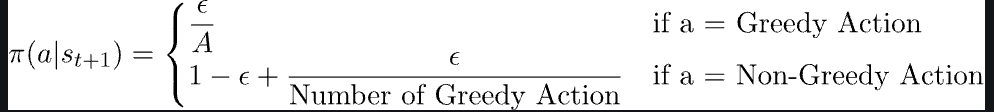

In [ ]:
def expsarsa(num_segments = 1000, theta = 0.001, alpha = 0.85, gamma = 0.90,
             epsilon=0.1):

  Q = np.zeros([env.observation_space.n, env.action_space.n])

  train = []
  test = []

  for j in range(num_segments):

    for i in range(10):
      state = env.reset()[0]
      rAll = 0
      done = False

      k = 0

      while not done:

        expected_q = 0
        
        action = softmax(Q, state, theta = theta)

        new_state, reward, done, _, _ = env.step(action)

        _max = np.max(Q[new_state, :])
        _maxcnt = 0

        for _a in range(4):
            if Q[new_state, _a] == _max:
                _maxcnt += 1

        ngap = epsilon/4 # non-greedy action probability

        gap = (1-epsilon)/_maxcnt + ngap # greedy action probability

        for _a in range(4):
            if Q[new_state, _a] == _max:
              expected_q += Q[new_state][_a] * gap
            else:
              expected_q += Q[new_state][_a] * ngap

        Q[state, action] = (Q[state, action] + 
                            alpha * (reward + gamma * 
                                      expected_q - Q[state, action]))
        rAll += gamma**k * reward
        state = new_state

        k+=1

      train.append(rAll)

    s = env.reset()[0]
    a = greedy(s, Q)

    reward = 0
    k = 0

    done = False

    for t in range(100):

      s_, r, done, _, _ = env.step(a)
      a_ = greedy(s, Q)
      reward += gamma**k * r
      s = s_
      a = a_
      k+=1
      if done:
        break

    test.append(reward) 
    
  return Q, train, test

Let us visualize the optimal policy from Expected SARSA training on 500 segments.

We previously set theta=0.001, but it caused an overflow in the softmax on numerous occasions.

In [ ]:
Q, train, test = expsarsa(num_segments = 500, theta = 0.01, alpha = 0.1, gamma = 0.99)

print(np.array([greedy(s, Q) for s in range(16)]).reshape(4,4))

'''
0: LEFT

1: DOWN

2: RIGHT

3: UP
'''

print(env.render())
print(np.mean(train))

[[0 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 3 0]]
  (Left)
SFFF
FHFH
FFFH
HFFG

0.2530422759299526


The function below outputs average return on both SARSA/Expected SARSA in the last 20 segments for both training and testing.

In [ ]:
def returns(num_segments = 500, num_runs = 10, theta = 0.001, gamma = 0.90, alpha = 0.85):

  fin = []
  expfin = []

  fintest = []
  expfintest = []

  for run in range(num_runs):
    print(run)

    _, train, test = sarsa(num_segments = num_segments, theta = theta, 
                           alpha = alpha, gamma = gamma)
    fin.append(np.mean(train[-200:]))
    fintest.append(np.mean(test[-20:]))

    _, train, test = expsarsa(num_segments = num_segments, theta = theta, 
                              alpha = alpha, gamma = gamma)
    expfin.append(np.mean(train[-200:]))
    expfintest.append(np.mean(test[-20:]))
    
  return np.mean(fin), np.mean(expfin), np.mean(fintest), np.mean(expfintest)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


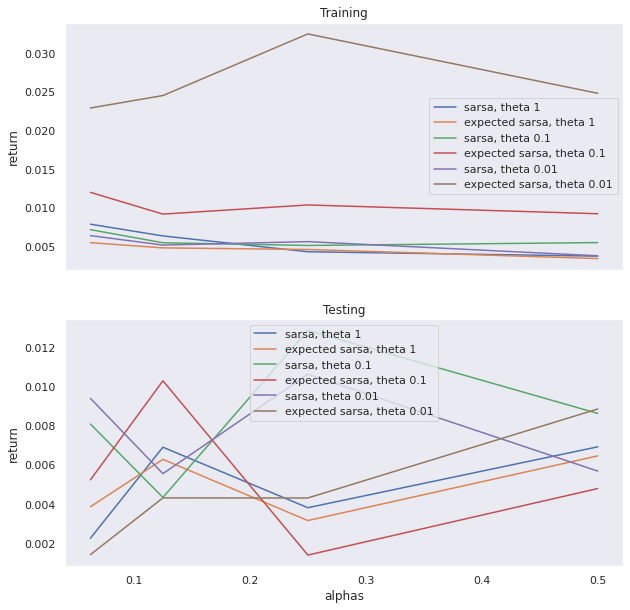

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

thetas = [1,
          0.1,
          0.01
          ]
alphas = [1/2, 1/4, 1/8, 1/16]

figure, axes = plt.subplots(2, 1, sharex=True, figsize=(10,10))
axes[0].set_title('Training')
axes[1].set_title('Testing')

for theta in thetas:
  x_train_sarsa = []
  x_test_sarsa = []
  x_train_expsarsa = []
  x_test_expsarsa = []
  for alpha in alphas:
    train_sarsa, train_expsarsa, test_sarsa, test_expsarsa = returns(
        num_segments = 500, num_runs = 10, theta = theta, gamma = 0.90, 
        alpha = alpha)
    x_train_sarsa.append(train_sarsa)
    x_test_sarsa.append(test_sarsa)
    x_train_expsarsa.append(train_expsarsa)
    x_test_expsarsa.append(test_expsarsa)

  x_train_sarsa = np.array(x_train_sarsa)
  x_train_expsarsa = np.array(x_train_expsarsa)

  x_train_sarsa = pd.DataFrame({'alphas': np.array(alphas), 
                                'return': x_train_sarsa})
  x_train_expsarsa = pd.DataFrame({'alphas': np.array(alphas), 
                                   'return': x_train_expsarsa})
  
  x_test_sarsa = np.array(x_test_sarsa)
  x_test_expsarsa = np.array(x_test_expsarsa)

  x_test_sarsa = pd.DataFrame({'alphas': np.array(alphas), 
                                'return': x_test_sarsa})
  x_test_expsarsa = pd.DataFrame({'alphas': np.array(alphas), 
                                   'return': x_test_expsarsa})
  
  sns.lineplot(ax = axes[0], data=x_train_sarsa, x="alphas", y="return", 
               label='sarsa, theta ' + str(theta))
  sns.lineplot(ax = axes[0], data=x_train_expsarsa, x="alphas", y="return", 
               label='expected sarsa, theta ' + str(theta))
  
  sns.lineplot(ax = axes[1], data=x_test_sarsa, x="alphas", y="return", 
               label='sarsa, theta ' + str(theta))
  sns.lineplot(ax = axes[1], data=x_test_expsarsa, x="alphas", y="return", 
               label='expected sarsa, theta ' + str(theta))
  


Based on both the training and testing plots, we found the best parameters to be theta = 0.01 and alpha = 1/8 for both SARSA and Expected SARSA.

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


<AxesSubplot:xlabel='time', ylabel='return'>

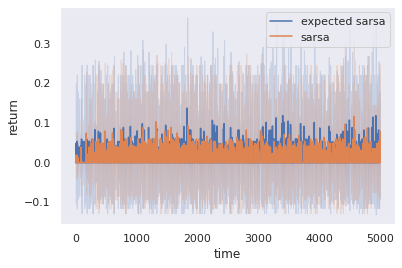

In [ ]:
for i in range(10):
  print(i)
  _, train, _ = expsarsa(num_segments = 500, theta = 0.1, 
                           alpha = 1/8, gamma = 0.9)
  
  if i>0:
    b = np.concatenate((np.arange(5000).reshape(5000,1), 
                        np.array(train).reshape(5000,1)), axis=1)
    a = np.concatenate((a,b),axis=0)

  else:
    a = np.concatenate((np.arange(5000).reshape(5000,1), 
                        np.array(train).reshape(5000,1)), axis=1)

df = pd.DataFrame(a, columns=['time','return'])

sns.set(style='dark',)
sns.lineplot(data=df, x= 'time', y = 'return', ci='sd', 
             label='expected sarsa'#, errorbar='sd',err_style="band"
             )

#================================================

for i in range(10):
  print(i)
  _, train, _ = sarsa(num_segments = 500, theta = 0.1, 
                           alpha = 1/4, gamma = 0.9)
  

  
  if i>0:
    b = np.concatenate((np.arange(5000).reshape(5000,1), 
                        np.array(train).reshape(5000,1)), axis=1)
    a = np.concatenate((a,b),axis=0)

  else:
    a = np.concatenate((np.arange(5000).reshape(5000,1), 
                        np.array(train).reshape(5000,1)), axis=1)

df = pd.DataFrame(a, columns=['time','return'])

sns.set(style='dark',)
sns.lineplot(data=df, x= 'time', y = 'return', ci='sd', 
             label='sarsa'#, errorbar='sd',err_style="band"
             )

In this experiment, we compared SARSA with Expected SARSA using Boltzmann / softmax exploration for training and greedy for testing. We used 3 settings of temperature (i.e. 1, 0.1, 0.01) and 4 settings of learning rate (i.e. 1/2, 1/4, 1/8, 1/16) to better visualize the shape of the curves in the Training and Testing plots above. 

From the graphs, we make two major observations. First, as for temperature in the Boltzmann / softmax exploration, both SARSA and Expected SARSA perform best with a rather lower value (e.g. 0.1 in both the Training and Testing plots and 0.01 doing well in the Testing plot), a sub-1 value causes the preference to be drastically amplified by the exponentiation in the softmax equation, causing the exploration to behave more like greedy. 

Looking at the Training and Testing graph, we picked the best parameters to be temperatuer 0.1, learning rate 0.25 for SARSA and learning rate 0.125 for Expected SARSA from an eyeball analysis, but due to the stochastic nature of the game, we highlight that results may vary.

Second, we observed from Plot 3 that optimal parameters Expected SARSA has slightly higher average returns that optimal parameters SARSA. 

In [1]:
import numpy as np
import gymnasium as gym
import torch
from torch.autograd import Variable
env = gym.make('CartPole-v1')
observation = env.reset()[0]

#design the bins
def test_bounding(env):
    obs = []
    for i in range(10000):
        observation = env.reset()[0]
        done = False
        while not done:
            action = env.action_space.sample()
            observation,reward,done,truncation,_ = env.step(action)
            obs.append(observation)
            if truncation:
                done = True
    
    maximum = np.max(obs,axis = 0)
    minimum = np.min(obs,axis = 0)
    return maximum,minimum

up,low = test_bounding(env)
print(up,low)


[1.4358618 2.8903618 0.2681377 3.6028073] [-2.4241662  -2.841473   -0.26625106 -3.336596  ]


In [22]:
def observation2state(observation,bins):
    state = []
    for i in range(len(observation)):
        digit = np.digitize(observation[i],bins[i])
        state.append(digit)
    state = ''.join(str(digit) for digit in state)
    return int(state)

def action_selection(state,Q,n_action,epsilon):
    if np.random.random() < epsilon:
        action = np.random.randint(n_action)
    else:
        action = np.argmax(Q[state])
    return action

n_states = 4
n_actions = 2

#create the bins for each state by boundings tested before
x = np.linspace(-3,3,9)
cv = np.linspace(-4,4,9)
#cv = np.linspace(env.env.observation_space.low[1],env.env.observation_space.high[1],10)
a = np.linspace(-0.3,0.3,9)
av = np.linspace(-4,4,9)
#av = np.linspace(env.env.observation_space.low[3],env.env.observation_space.high[3],10)
bins = [x,cv,a,av]
print(observation2state(env.reset()[0],bins))

4454


In [13]:


def q_learning(env,seed,bins,alpha,epsilon,gamma = 0.95):
    ns = 10*10*10*10
    na = env.action_space.n
    np.random.seed(seed)
    #init weights in [-0.001,0.001]
    Q = np.random.rand(ns,na)/500-0.001
    n_episode = 1000
    rewards = []
    for episode in range(n_episode):
        observation = env.reset()[0]
        state = observation2state(observation,bins)
        done = False
        total_reward = 0
         
        while not done:
            action = action_selection(state,Q,na,epsilon)
            next_observation,reward,done,truncation,_ = env.step(action)
            if truncation:
                break
            total_reward += reward
            next_state = observation2state(next_observation,bins)
            #update Q value
            Q[state,action] += alpha*(reward+gamma*np.max(Q[next_state])-Q[state,action])
            state = next_state
        rewards.append(total_reward)
    return rewards

epsilon = 0.1

In [23]:
av_rewards_q1 = []
alpha = [1/4,1/8,1/16]
for i in range(3):
    av_reward = []
    for j in range(10):
        rewards= q_learning(env,j,bins,alpha[i],0.1)  
        av_reward.append(rewards)
    #av_reward = np.mean(av_reward,axis=0)
    av_rewards_q1.append(av_reward) 

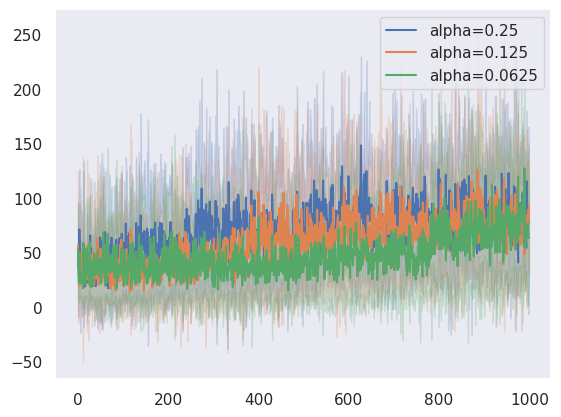

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
x = np.arange(1000)
x = np.tile(x,10)
av_rewards_q1 = np.array(av_rewards_q1)

sns.set(style='dark',)
for i in range(3):
    #plt.errorbar(x,av_rewards[i],err[i],label = 'alpha={}'.format(alpha[i]))
    sns.lineplot( x=x, y = av_rewards_q1[i].reshape(10000),label = 'alpha={}'.format(alpha[i]),errorbar='sd',err_style="band")

epsilon = 0.2

In [25]:
av_rewards_q2 = []
alpha = [1/4,1/8,1/16]
for i in range(3):
    av_reward = []
    for j in range(10):
        rewards= q_learning(env,j,bins,alpha[i],0.2)  
        av_reward.append(rewards)
    #av_reward = np.mean(av_reward,axis=0)
    av_rewards_q2.append(av_reward)   

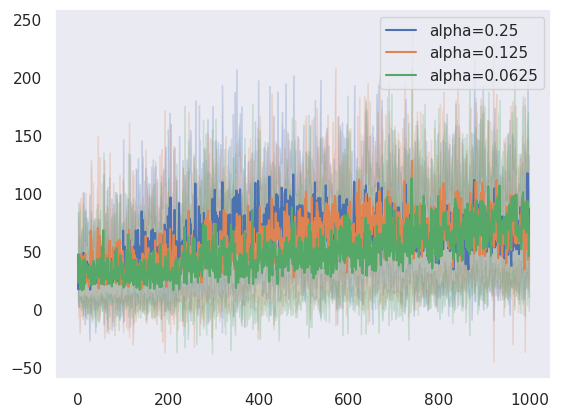

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
x = np.arange(1000)
x = np.tile(x,10)
av_rewards_q2 = np.array(av_rewards_q2)

sns.set(style='dark',)
for i in range(3):
    #plt.errorbar(x,av_rewards[i],err[i],label = 'alpha={}'.format(alpha[i]))
    sns.lineplot( x=x, y = av_rewards_q2[i].reshape(10000),label = 'alpha={}'.format(alpha[i]),errorbar='sd',err_style="band")

In [33]:
print(np.mean(av_rewards_q2[2].mean(axis=0)))

49.4785


epsilon = 0.4

In [27]:
av_rewards_q3 = []
alpha = [1/4,1/8,1/16]
for i in range(3):
    av_reward = []
    for j in range(10):
        rewards= q_learning(env,j,bins,alpha[i],0.4)  
        av_reward.append(rewards)
    #av_reward = np.mean(av_reward,axis=0)
    av_rewards_q3.append(av_reward) 

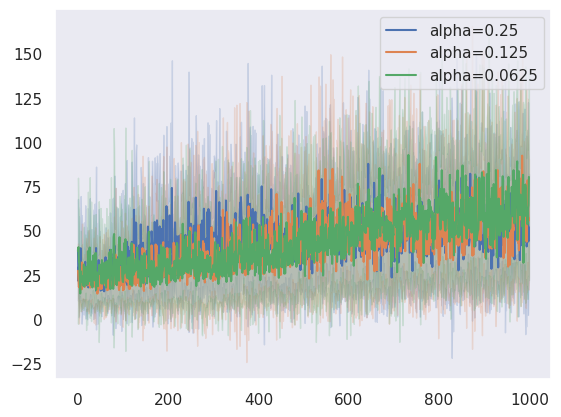

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
x = np.arange(1000)
x = np.tile(x,10)
av_rewards_q3 = np.array(av_rewards_q3)

sns.set(style='dark',)
for i in range(3):
    #plt.errorbar(x,av_rewards[i],err[i],label = 'alpha={}'.format(alpha[i]))
    sns.lineplot( x=x, y = av_rewards_q3[i].reshape(10000),label = 'alpha={}'.format(alpha[i]),errorbar='sd',err_style="band")

Actor-Critic

In [36]:
def actor_critic(env,seed,bins,alpha,epsilon,gamma=0.95):
    na = env.action_space.n
    ns = 10*10*10*10
    np.random.seed(seed)
    actor =  np.random.rand(ns,na)/500-0.001
    critic = np.random.rand(ns)/500-0.001
    n_episode = 1000
    rewards = []
    for episode in range(n_episode):
        observation = env.reset()[0]
        state = observation2state(observation,bins)
        done = False
        total_reward = 0
         
        while not done:
            action = action_selection(state,actor,na,epsilon)
            next_observation,reward,done,truncation,_ = env.step(action)
            if truncation:
                break
            total_reward += reward
            next_state = observation2state(next_observation,bins)
            delta = reward+gamma*critic[next_state]-critic[state]
            #update values
            critic[state] += alpha*delta
            actor[state,action] += alpha*delta
            state = next_state
        rewards.append(total_reward)
    return rewards

epsilon = 0.1

In [39]:
av_rewards_ac1 = []
alpha = [1/4,1/8,1/16]
for i in range(3):
    av_reward = []
    for j in range(10):
        rewards= actor_critic(env,j,bins,alpha[i],0.1)  
        av_reward.append(rewards)
    av_rewards_ac1.append(av_reward) 

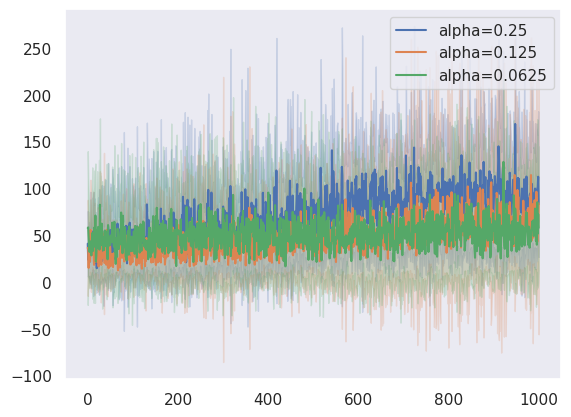

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
x = np.arange(1000)
x = np.tile(x,10)
av_rewards_ac1 = np.array(av_rewards_ac1)

sns.set(style='dark',)
for i in range(3):
    #plt.errorbar(x,av_rewards[i],err[i],label = 'alpha={}'.format(alpha[i]))
    sns.lineplot( x=x, y = av_rewards_ac1[i].reshape(10000),label = 'alpha={}'.format(alpha[i]),errorbar='sd',err_style="band")

epsilon=0.2

In [43]:
av_rewards_ac2 = []
alpha = [1/4,1/8,1/16]
for i in range(3):
    av_reward = []
    for j in range(10):
        rewards= actor_critic(env,j,bins,alpha[i],0.2)  
        av_reward.append(rewards)
    av_rewards_ac2.append(av_reward) 

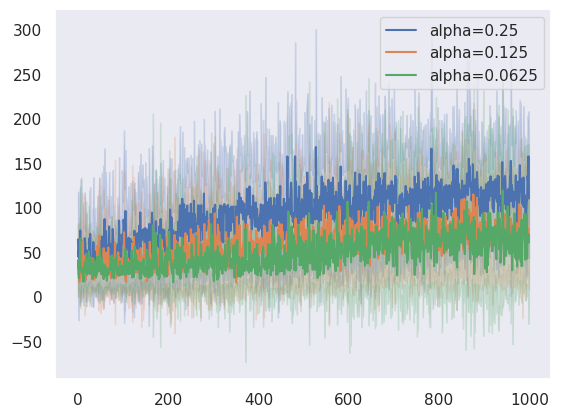

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
x = np.arange(1000)
x = np.tile(x,10)
av_rewards_ac2 = np.array(av_rewards_ac2)
sns.set(style='dark',)
for i in range(3):
    #plt.errorbar(x,av_rewards[i],err[i],label = 'alpha={}'.format(alpha[i]))
    sns.lineplot( x=x, y = av_rewards_ac2[i].reshape(10000),label = 'alpha={}'.format(alpha[i]),errorbar='sd',err_style="band")

epsilon=0.4

In [45]:
av_rewards_ac3 = []
alpha = [1/4,1/8,1/16]
for i in range(3):
    av_reward = []
    for j in range(10):
        rewards= actor_critic(env,j,bins,alpha[i],0.4)  
        av_reward.append(rewards)
    av_rewards_ac3.append(av_reward)   

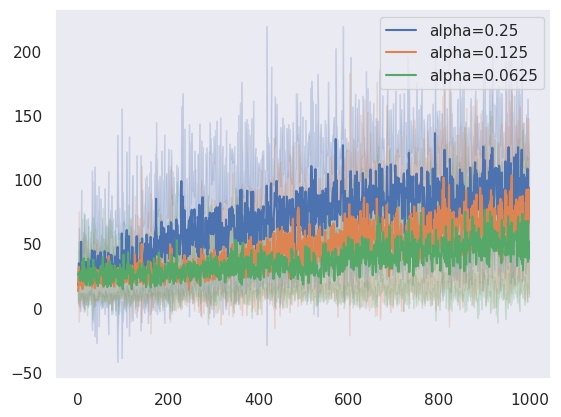

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
x = np.arange(1000)
x = np.tile(x,10)
av_rewards_ac3 = np.array(av_rewards_ac3)
sns.set(style='dark',)
for i in range(3):
    #plt.errorbar(x,av_rewards[i],err[i],label = 'alpha={}'.format(alpha[i]))
    sns.lineplot( x=x, y = av_rewards_ac3[i].reshape(10000),label = 'alpha={}'.format(alpha[i]),errorbar='sd',err_style="band")

comparison 

<AxesSubplot: >

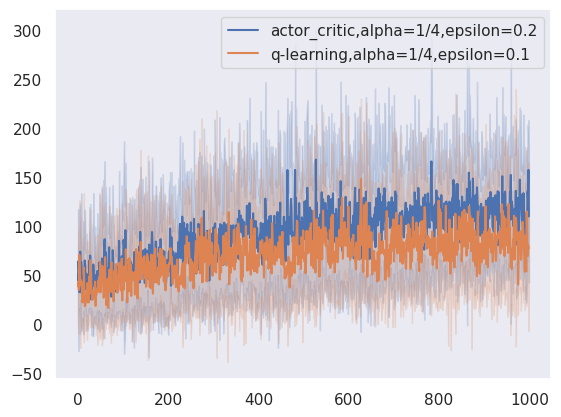

In [48]:
sns.lineplot( x=x, y = av_rewards_ac2[0].reshape(10000),label = 'actor_critic,alpha=1/4,epsilon=0.2',errorbar='sd',err_style="band")
sns.lineplot( x=x, y = av_rewards_q1[0].reshape(10000),label = 'q-learning,alpha=1/4,epsilon=0.1',errorbar='sd',err_style="band")


Conclusion
1. Selection of bins. I tested on random sampling actions and record the state space. That state space will be the most possible states show in the experiment. For the two unbounded states, we set the bound to the (min-epsilon,max+epsilon) to be the bound of the bin. To make sure all states are in the bins, I set 8 bins inside this bound and 2 extra outside. 

2. Selection of function approxiamator. I selected features as num_states*num_actions, which actually discrete the state space and do Tabular learning. I also tested set one-hot encoding, such as 40 length binary coding, at this problem the coding method I chose performs better.

3. Learning rate: smaller learning rate lead to smaller std error, however it can't achieve a good average reward, espicially in actor-critic. 

4. The best parameters for Q-learning are alpha=1/4, epsilon=0.1. Actor-critic, alpha=1/4, epsilon =0.2. And in that settings, actor-critic performs better, which has better average rewards and similar std error.